# Análisis de los Resultados de MCTSBN-distrubited

Investigadores: Jorge Daniel Laborda y Pablo Torrijos

Directores de Tesis: José Antonio Gámez y José Miguel Puerta

En Julio de 2023 lanzamos unos experimentos con la última versión de mctsbn. (Añadir versión aquí)

MCTSBN usa las estapas del algoritmo Montecarlo Tree Search [(wiki)](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search) para realizar un aprendizaje estructural de un conjunto de datos. El algoritmo funciona con variables discretas. 

El objetivo del MCTSBN es encontrar el mejor orden topológico en un tiempo o número de iteraciones estimado. Esta versión MCTSBN-distributed lanza en paralelo los cálculos que se pueden hacer simultáneamente. El MCTSBN consta de cinco etapas:

0. **Calentamiento**: Se ejecuta un algoritmo PGES para establecer un buen orden topológico inicial. Esto hace que la búsqueda sea mucho más rápida y se acote la exploración a un subconjunto del espacio de búsqueda. El calentamiento genera un conjunto de órdenes topológicos del resultado del pges para que se tengan en cuenta en la etapa RollOut. Acto seguido se realiza una iteración Expansión-Rollout-Backpropagation (E-R-B) para cada uno de los nodos del problema para que el árbol ya haya explorado cada nodo de primer nivel al menos una vez. Al terminar, se aplica una normalización del score para que la métrica UCT original quede normalizado a partir de este momento y se tenga un valor positivo entre 0 y 1. Por último se actualiza el score de cada nodo del árbol con esta normalización.
1. **Selección**: En esta etapa se selecciona el mejor nodo del árbol de búsqueda usando para ello una variación de la métrica UCT. Como estamos usando paralelismo, se pueden seleccionar simultáneamente los *k* mejores nodos del árbol.
2. **Expansión**: Cada nodo seleccionado es expandido, generando así hijos para cada nodo seleccionado. Este número de hijos depende de la constande de expansión que se establezca.
3. **RollOut**: Con cada nodo generado se realiza una simulación o rollout usando el algoritmo HillClimbing. Aquí se genera un orden usando el orden parcial obtenido (nodos desde la raíz hasta el nodo generado) y uniendolo a otro orden aleatorio generado en la fase de calentamiento. A parte de esto, se considera hacer intercambios pequeños entre las variables de forma aleatoria. Las constantes de propapilidad establecen con cuan frecuencia se producen estos intercambios.
4. **BackPropagation**: Ahora se actualizan simultáneamente los nodos previos del árbol (número de visitas, score...). Esto se hace para cada nodo que ha realizado un rollout.


 
![Etapas del MCTS](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/MCTS-steps.svg/1600px-MCTS-steps.svg.png)


# 1. Lectura de datos y preprocesamiento

En esta sección leemos los datos de los resultados y aplicacmos un preprocesamiento para que los datos sean más limpios.

**Librerías**

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
%load_ext rpy2.ipython

In [3]:
path_results_final = "../../results/galgo/mctsbn-distributed/results-final/results.csv"
path_results_iterations = "../../results/galgo/mctsbn-distributed/results-it/results.csv"

In [4]:
df = pd.read_csv(path_results_final)
df.head()

,algorithm,network,bbdd,threads,itLimit,exploitConst,selectionConst,numSwaps,probSwap,bdeuMCTS,...,timeMCTS,bdeuPGES,shdPGES,timePGES,bdeuOrig,shdOrig,bdeuPerfect,shdPerfect,timePerfect,timeSpentSavingRoundsSeconds
0,mctsbn-distributed,andes,andes.xbif50001246_,16,10000,50.0,1,0.0,0.0,-471620.756706,...,278.392,-471620.756706,164.0,15.732,-472457.682483,0.0,-471620.756706,164.0,0.022,0.649
1,mctsbn-distributed,andes,andes.xbif50001246_,16,10000,50.0,1,0.5,0.0,-471620.756706,...,278.139,-471620.756706,164.0,15.581,-472457.682483,0.0,-471620.756706,164.0,0.031,0.553
2,mctsbn-distributed,andes,andes.xbif50001246_,16,10000,50.0,1,1.0,0.0,-471602.154252,...,405.323,-471620.756706,164.0,16.864,-472457.682483,0.0,-471621.474145,161.0,0.039,0.642
3,mctsbn-distributed,andes,andes.xbif50001246_,16,10000,50.0,1,0.0,0.5,-471620.756706,...,273.272,-471620.756706,164.0,15.614,-472457.682483,0.0,-471624.744505,164.0,0.028,0.545
4,mctsbn-distributed,andes,andes.xbif50001246_,16,10000,50.0,1,0.5,0.5,-471620.756706,...,295.184,-471620.756706,164.0,15.382,-472457.682483,0.0,-471620.756706,164.0,0.027,0.673


Veamos cuántos valores tiene cada columna:

In [5]:
df.columns

Index(['algorithm', 'network', 'bbdd', 'threads', 'itLimit', 'exploitConst',
       'selectionConst', 'numSwaps', 'probSwap', 'bdeuMCTS', 'shdMCTS',
       'timeMCTS', 'bdeuPGES', 'shdPGES', 'timePGES', 'bdeuOrig', 'shdOrig',
       'bdeuPerfect', 'shdPerfect', 'timePerfect',
       'timeSpentSavingRoundsSeconds'],
      dtype='object')

In [6]:
# unique values of network
df["network"].unique()

array(['andes', 'diabetes', 'hailfinder', 'hepar2', 'link', 'munin',
       'pigs', 'win95pts'], dtype=object)

In [7]:
#Find bbdd with ALL in the name
df[df["network"].str.contains("ALL")]["network"].unique()

array([], dtype=object)

In [8]:
for col in df.columns:
    print("Number of unique values for column " + col + ": " + str(len(df[col].unique())))

Number of unique values for column algorithm: 1
Number of unique values for column network: 8
Number of unique values for column bbdd: 88
Number of unique values for column threads: 1
Number of unique values for column itLimit: 6
Number of unique values for column exploitConst: 1
Number of unique values for column selectionConst: 6
Number of unique values for column numSwaps: 3
Number of unique values for column probSwap: 3
Number of unique values for column bdeuMCTS: 1653
Number of unique values for column shdMCTS: 413
Number of unique values for column timeMCTS: 4706
Number of unique values for column bdeuPGES: 192
Number of unique values for column shdPGES: 111
Number of unique values for column timePGES: 3798
Number of unique values for column bdeuOrig: 88
Number of unique values for column shdOrig: 1
Number of unique values for column bdeuPerfect: 3002
Number of unique values for column shdPerfect: 468
Number of unique values for column timePerfect: 1474
Number of unique values fo

### Análisis del Preprocesamiento

* Las columnas que solo tienen un valor no aportan ningún valor añadido al conjunto de datos. 
* También hay que tener en cuenta que como vamos a realizar una media de los resultados por red, la columna `bbdd` no aporta valor. Lo usaremos para agrupar los datos de los mismos experimentos, pero acto seguido lo borraremos.
* La columna `timeSpentSavingRoundsSeconds`habría que usarla para restar el valor a la columna `timeMCTS`. Vamos a crear una nueva columna llamada `realTimeMCTS` que será igual a: `realTimeMCTS = timeMCTS - timeSpentSavingRoundsSeconds`. Después eliminaremos las columnas `timeMCTS`  y `timeSpentSavingRoundsSeconds`.
* La columna `itLimit` es dependiente directo del valor de la constante de selección ya que `itLimit = 10000 / selectionConst`. Vamos a eliminar esta columna
* Las columnas de las métricas de las distintas partes del algoritmo mctsbn (pges, original y mcts) pueden estar en las mismas columnas. Es decir, vamos a crear tres columnas (bdeu, shd y time) donde se almacenen los valores de estas métricas, cambiando acordemente la columna `algorithm` para que tenga reflejado a qué corresponde la métrica. (Esto lo hacemos en el método `tidy_data(df)`)

Procedemos a realizar el preprocesamiento definiendo el método `preprocess(df)`.

In [9]:
def preprocess(df):
    df = df.drop(["threads", "exploitConst", "shdOrig"],axis=1) # Deleting columns with one value
    #df = df.drop(["bbdd"], axis=1) # Deleting column of databases
    df = df.drop("algorithm", axis=1) # Deleting algorithm column
    df['realTimeMCTS'] = df['timeMCTS'] - df['timeSpentSavingRoundsSeconds'] # Creating new column realTimeMCTS
    df = df.drop(['timeMCTS', 'timeSpentSavingRoundsSeconds'], axis=1) # Deleting columns 
    df = df.drop("itLimit", axis=1) # Deleting itLimit
    return df

Aplicamos el preprocesamiento:

In [10]:
df = pd.read_csv(path_results_final)
df = preprocess(df)
df

,network,bbdd,selectionConst,numSwaps,probSwap,bdeuMCTS,shdMCTS,bdeuPGES,shdPGES,timePGES,bdeuOrig,bdeuPerfect,shdPerfect,timePerfect,realTimeMCTS
0,andes,andes.xbif50001246_,1,0.0,0.0,-471620.756706,164.0,-471620.756706,164.0,15.732,-472457.682483,-471620.756706,164.0,0.022,277.743
1,andes,andes.xbif50001246_,1,0.5,0.0,-471620.756706,164.0,-471620.756706,164.0,15.581,-472457.682483,-471620.756706,164.0,0.031,277.586
2,andes,andes.xbif50001246_,1,1.0,0.0,-471602.154252,158.0,-471620.756706,164.0,16.864,-472457.682483,-471621.474145,161.0,0.039,404.681
3,andes,andes.xbif50001246_,1,0.0,0.5,-471620.756706,164.0,-471620.756706,164.0,15.614,-472457.682483,-471624.744505,164.0,0.028,272.727
4,andes,andes.xbif50001246_,1,0.5,0.5,-471620.756706,164.0,-471620.756706,164.0,15.382,-472457.682483,-471620.756706,164.0,0.027,294.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,win95pts,win95pts.xbif_,16,0.5,0.5,-46816.258978,54.0,-46977.991350,65.0,5.166,-46896.435883,-46803.642264,32.0,0.014,38.242
4740,win95pts,win95pts.xbif_,16,1.0,0.5,-46840.901743,61.0,-46977.991350,65.0,5.084,-46896.435883,-46998.325749,34.0,0.010,41.261
4741,win95pts,win95pts.xbif_,16,0.0,1.0,-46977.991350,65.0,-46977.991350,65.0,4.864,-46896.435883,-46998.325749,34.0,0.017,25.471
4742,win95pts,win95pts.xbif_,16,0.5,1.0,-46922.166402,61.0,-46977.991350,65.0,5.038,-46896.435883,-46804.375793,28.0,0.011,45.191


In [11]:
df = pd.read_csv(path_results_final)
df[df["network"] == "link"]

,algorithm,network,bbdd,threads,itLimit,exploitConst,selectionConst,numSwaps,probSwap,bdeuMCTS,...,timeMCTS,bdeuPGES,shdPGES,timePGES,bdeuOrig,shdOrig,bdeuPerfect,shdPerfect,timePerfect,timeSpentSavingRoundsSeconds
2375,mctsbn-distributed,link,link.xbif50001246_,16,10000,50.0,1,0.0,0.0,-1.123349e+06,...,2127.039,-1.121275e+06,899.0,235.968,-1.088478e+06,0.0,-1.134250e+06,525.0,1.027,0.499
2376,mctsbn-distributed,link,link.xbif50001246_,16,10000,50.0,1,0.5,0.0,-1.121275e+06,...,2091.902,-1.121275e+06,899.0,236.886,-1.088478e+06,0.0,-1.116540e+06,558.0,0.689,0.549
2377,mctsbn-distributed,link,link.xbif50001246_,16,10000,50.0,1,1.0,0.0,-1.124751e+06,...,2096.423,-1.121275e+06,899.0,241.351,-1.088478e+06,0.0,-1.124214e+06,540.0,0.883,0.521
2378,mctsbn-distributed,link,link.xbif50001246_,16,10000,50.0,1,0.0,0.5,-1.121559e+06,...,2099.780,-1.121275e+06,899.0,240.530,-1.088478e+06,0.0,-1.124157e+06,508.0,0.857,0.469
2379,mctsbn-distributed,link,link.xbif50001246_,16,10000,50.0,1,0.5,0.5,-1.121791e+06,...,4843.286,-1.121275e+06,899.0,239.770,-1.088478e+06,0.0,-1.127197e+06,517.0,0.407,0.577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957,mctsbn-distributed,link,link.xbif_,16,625,50.0,16,0.5,0.5,-1.120612e+06,...,3313.525,-1.125719e+06,898.0,228.127,-1.088534e+06,0.0,-1.120533e+06,509.0,0.420,0.218
2958,mctsbn-distributed,link,link.xbif_,16,625,50.0,16,1.0,0.5,-1.121998e+06,...,4883.871,-1.125719e+06,898.0,227.913,-1.088534e+06,0.0,-1.117287e+06,526.0,0.234,0.242
2959,mctsbn-distributed,link,link.xbif_,16,625,50.0,16,0.0,1.0,-1.118647e+06,...,901.544,-1.125719e+06,898.0,227.551,-1.088534e+06,0.0,-1.113371e+06,458.0,0.982,0.096
2960,mctsbn-distributed,link,link.xbif_,16,625,50.0,16,0.5,1.0,-1.117610e+06,...,5238.861,-1.125719e+06,898.0,226.273,-1.088534e+06,0.0,-1.128684e+06,658.0,0.379,0.215


Vamos a catalogar las columnas:

In [12]:
param_columns = ["network", "bbdd", "selectionConst", "numSwaps", "probSwap"]
time_columns = list(df.filter(like='time').columns) + ["realTimeMCTS"]
bdeu_columns = list(df.filter(like='bdeu').columns)
shd_columns = list(df.filter(like='shd').columns)
measure_columns = [x for x in list(df.columns.values) if x not in param_columns]
column_dict = {"param" : param_columns, "time": time_columns, "bdeu": bdeu_columns, "shd": shd_columns, "measure": measure_columns}
for key in column_dict:
    print("Columnas " + key + ": " + str(column_dict[key]))

Columnas param: ['network', 'bbdd', 'selectionConst', 'numSwaps', 'probSwap']
Columnas time: ['timeMCTS', 'timePGES', 'timePerfect', 'timeSpentSavingRoundsSeconds', 'realTimeMCTS']
Columnas bdeu: ['bdeuMCTS', 'bdeuPGES', 'bdeuOrig', 'bdeuPerfect']
Columnas shd: ['shdMCTS', 'shdPGES', 'shdOrig', 'shdPerfect']
Columnas measure: ['algorithm', 'threads', 'itLimit', 'exploitConst', 'bdeuMCTS', 'shdMCTS', 'timeMCTS', 'bdeuPGES', 'shdPGES', 'timePGES', 'bdeuOrig', 'shdOrig', 'bdeuPerfect', 'shdPerfect', 'timePerfect', 'timeSpentSavingRoundsSeconds']


### Análisis de Tidy Data

Tras hacer el preprocesamiento tenemos varias columns que representan la misma medida. A continuación, vamos a agrupar las mismas medidas en una única column, reduciendo así la cantidad de columnas, pero aumentando el número de filas del conjunto de datos final.
La agrupación será la siguiente:
* En la columna `bdeu` agruparemos: `bdeuMCTS`, `bdeuPGES`, `bdeuOrig` y `bdeuPerfect`.
* En la column `shd` agruparemos: `shdMCTS`, `shdPGES` y `shdPerfect`.
* En la column `time` agruparemos: `timeMCTS`, `timePGES` y `timePerfect`.

Después rellenaremos los valores nulos de los valores de `time` y `shd` que se originan por los valores de `bdeuOrig` con 0. Tiene lógica que el tiempo y el shd de la estrutura original sea 0.

Las columnas tienen el siguiente siginificado:
* "MCTS" corresponde a la puntuación obtenida por el algoritmo de MCTSBN al final de su ejecución
* "PGES" corresponde a la puntuación obtenida al comienzo del MCTSBN cuando se ejecuta el PGES.
* "Orig" corresponde a la puntuación de la red original. Solo se hace con el bdeu.
* "Perfect" corresponde a la puntuación obtenida cuando usamos un orden perfecto con el que se debería obtener la red óptima.

Finalmente agrupamos estas columnas en la nueva column `algorithm` que ahora pasa a tener los valores previos.


In [13]:
def tidy_data(df):
    param_columns = ["network", "bbdd", "selectionConst", "numSwaps", "probSwap"]
    time_columns = list(df.filter(like='time').columns) + ["realTimeMCTS"]
    bdeu_columns = list(df.filter(like='bdeu').columns)
    shd_columns = list(df.filter(like='shd').columns)
    #measure_columns = [x for x in list(df.columns.values) if x not in param_columns]
    #column_dict = {"param" : param_columns, "time": time_columns, "bdeu": bdeu_columns, "shd": shd_columns, "measure": measure_columns}
    tidy_dict = {"bdeu" : bdeu_columns, "shd" : shd_columns, "time" : time_columns}
    replace_map = {"bdeu" : {"bdeuMCTS":"mcts", "bdeuPGES":"pges", "bdeuOrig": "original", "bdeuPerfect": "perfect"},
                   "shd"  : {"shdMCTS":"mcts", "shdPGES":"pges", "shdPerfect": "perfect"},
                   "time" : {"realTimeMCTS":"mcts", "timePGES":"pges", "timePerfect": "perfect"}
                  }

    dfs=[]
    for key in tidy_dict:
        cols = tidy_dict[key]
        #print("Doing extraction for " + str(cols))
        df_score = df[param_columns + cols]
        df_score = pd.melt(df_score, id_vars=param_columns,
                          value_vars=cols,
                          var_name="algorithm",
                          value_name=key)
        df_score["algorithm"].replace(to_replace=replace_map[key], inplace=True)
        #df_score.drop("algorithm", axis=1, inplace=True)
        #df_score.rename({key+"_score":"algorithm"}, axis=1,inplace=True)
        dfs.append(df_score)
        #print(df_score.head())
        #print("Shape: " + str(df_score.shape))

    df_tidy = pd.merge(dfs[0], dfs[1], how="left", on=param_columns + ["algorithm"])
    df_tidy = pd.merge(df_tidy, dfs[2], how="left", on=param_columns + ["algorithm"])

    #Dropping bbdd column
    df_tidy = df_tidy.drop("bbdd", axis=1)
    
    # Replacing NaN with 0
    df_tidy["shd"] = df_tidy["shd"].fillna(0)
    df_tidy["time"] = df_tidy["time"].fillna(0)
    
    
    return df_tidy

In [14]:
def findrows(df, network="andes", algorithm="mcts", selectionConst=1, numSwaps=0.0, probSwap=0.0 ):
    return df[(df["network"] == network) & (df["algorithm"] == algorithm) & (df["selectionConst"] == selectionConst) & (df["numSwaps"] == numSwaps) & (df["probSwap"] == probSwap)]#.groupby(["selectionConst", "numSwaps", "probSwap", "algorithm"]).count()

In [15]:
def pipeline(df=pd.read_csv(path_results_final)):
    df = preprocess(df)
    df = tidy_data(df)
    return df

In [16]:
df = pd.read_csv(path_results_final)
df = preprocess(df)

df_tidy = tidy_data(df)
print("Shape: " + str(df_tidy.shape))
df_tidy

Shape: (18976, 8)


,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471620.756706,164.0,277.743
1,andes,1,0.5,0.0,mcts,-471620.756706,164.0,277.586
2,andes,1,1.0,0.0,mcts,-471602.154252,158.0,404.681
3,andes,1,0.0,0.5,mcts,-471620.756706,164.0,272.727
4,andes,1,0.5,0.5,mcts,-471620.756706,164.0,294.511
...,...,...,...,...,...,...,...,...
18971,win95pts,16,0.5,0.5,perfect,-46803.642264,32.0,0.014
18972,win95pts,16,1.0,0.5,perfect,-46998.325749,34.0,0.010
18973,win95pts,16,0.0,1.0,perfect,-46998.325749,34.0,0.017
18974,win95pts,16,0.5,1.0,perfect,-46804.375793,28.0,0.011


In [17]:
# Validating data
rows_with_none = df_tidy[df_tidy.isna().any(axis=1)]
assert len(rows_with_none) == 0
assert len(df_tidy) == 4744*4

# 2. Análisis Estadístico de los datos

In [18]:
# Aplicamos el preprocesamiento entero
df = pipeline()
df

,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471620.756706,164.0,277.743
1,andes,1,0.5,0.0,mcts,-471620.756706,164.0,277.586
2,andes,1,1.0,0.0,mcts,-471602.154252,158.0,404.681
3,andes,1,0.0,0.5,mcts,-471620.756706,164.0,272.727
4,andes,1,0.5,0.5,mcts,-471620.756706,164.0,294.511
...,...,...,...,...,...,...,...,...
18971,win95pts,16,0.5,0.5,perfect,-46803.642264,32.0,0.014
18972,win95pts,16,1.0,0.5,perfect,-46998.325749,34.0,0.010
18973,win95pts,16,0.0,1.0,perfect,-46998.325749,34.0,0.017
18974,win95pts,16,0.5,1.0,perfect,-46804.375793,28.0,0.011


Separamos las columnas de parámetros de las columnas de mediciones

In [19]:
param_columns = ["network", "selectionConst", "numSwaps", "probSwap", "algorithm"]
measure_columns = [x for x in list(df.columns.values) if x not in param_columns]

Contamos el número de combinaciones de parámetros que hemos realizado (432)

In [20]:
unique_combinations = df.drop_duplicates(subset=["network", "selectionConst", "numSwaps", "probSwap"])
len(unique_combinations[param_columns])

432

Tenemos 11 bases de datos distintos que se ejecuta una vez para cada una de estas combinaciones. Es decir, hay un total de 432 * 11 = 4752 experimentos. Comprobamos si es así. Si no es así, hay que recopilar los experimentos restantes. (Falta añadir los últimos 8 experimentos restantes)

In [21]:
len(pd.read_csv(path_results_final))

4744

In [22]:
432*11

4752

In [23]:
print(432 * 11 == len(pd.read_csv(path_results_final)))
print("Faltan " + str(432*11 - len(pd.read_csv(path_results_final))) + " experimentos por hacer")

False
Faltan 8 experimentos por hacer


In [24]:
import pandas as pd
from itertools import product

def findMissingExperiments():
    # Assuming your dataframe is named 'df'
    df = pd.read_csv(path_results_final)
    # Create a list of unique combinations in your dataframe
    unique_combinations = df[['selectionConst', 'numSwaps', 'probSwap', 'bbdd']].drop_duplicates()

    # Define all possible values for each parameter used in the experiments
    networks = ['andes', 'diabetes', 'hailfinder', 'hepar2', 'link', 'munin', 'pigs', 'win95pts']
    selectionConsts = [1, 8, 4, 32, 2, 16]
    numSwaps = [0, 0.5, 1]
    probSwaps = [0, 0.5, 1]
    database_endings = (".xbif_", ".xbif50001_", ".xbif50002_", ".xbif50003_", ".xbif50004_",
                        ".xbif50005_", ".xbif50006_", ".xbif50007_", ".xbif50008_", ".xbif50009_", ".xbif50001246_")

    # Generate all possible bbdd values based on network and database_endings combinations
    databases = [x + y for x in networks for y in database_endings]

    # Create a list of all possible combinations
    all_possible_combinations = pd.DataFrame(list(product(selectionConsts, numSwaps, probSwaps, databases)),
                                            columns=[ 'selectionConst', 'numSwaps', 'probSwap', 'bbdd'])

    # Merge the dataframes and identify the missing experiments
    merged = all_possible_combinations.merge(unique_combinations, on=['selectionConst', 'numSwaps', 'probSwap', 'bbdd'], how='left', indicator=True)
    missing_experiments = merged[merged['_merge'] == 'left_only'].drop(columns=['_merge'])

    # Display the missing experiments
    print(missing_experiments)

Los experimentos que faltan son los siguientes:

In [25]:
findMissingExperiments()

      selectionConst  numSwaps  probSwap                    bbdd
221                1       0.0       1.0         link.xbif50001_
813                8       0.0       0.0  diabetes.xbif50001246_
3124              32       1.0       1.0              link.xbif_
3831               2       1.0       0.5         link.xbif50003_
3916               2       1.0       1.0              link.xbif_
3919               2       1.0       1.0         link.xbif50003_
4181              16       0.0       1.0         link.xbif50001_
4447              16       0.5       1.0         link.xbif50003_


---

Agrupamos los experimentos usando las columnas de parámetros como llaves del groupby y aplicamos una media de cada uno de los 11 experimentos

In [26]:
df_mean = df.groupby(param_columns, as_index=False).mean()
df_mean

,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471573.247638,150.090909,296.539636
1,andes,1,0.0,0.0,original,-472472.535183,0.000000,0.000000
2,andes,1,0.0,0.0,perfect,-471988.264459,152.818182,0.028727
3,andes,1,0.0,0.0,pges,-471582.205027,151.727273,16.157273
4,andes,1,0.0,0.5,mcts,-471573.248826,150.636364,274.674727
...,...,...,...,...,...,...,...,...
1723,win95pts,32,1.0,0.5,pges,-47054.862053,56.454545,4.743818
1724,win95pts,32,1.0,1.0,mcts,-46918.738320,44.636364,45.719636
1725,win95pts,32,1.0,1.0,original,-46928.974504,0.000000,0.000000
1726,win95pts,32,1.0,1.0,perfect,-46871.235187,33.454545,0.009182


## Tablas de Resultados
Aquí representamos todos los resultados medios de cada medida en función de los parámetros usados para los experimentos.

In [27]:
# Aumentando el número de registros que se muestran por pantalla
#pd.set_option('display.max_rows', 300)
#pd.set_option('display.max_columns', 300)

### Resultado Tiempo MCTSBN-distributed

In [28]:
#df_results = df.drop(["bdeu", "shd"], axis=1)
#df_results.groupby(param_columns,observed=True).mean().unstack(0)

---
### Resultado BDeu MCTSBN-distributed

In [29]:
#df_results = df.drop(["time", "shd"], axis=1)
#df_results.groupby(param_columns,observed=True).mean().unstack(0)

---
### Resultado SHD MCTSBN-distributed

In [30]:
#df_results = df.drop(["bdeu", "time"], axis=1)
#df_results.groupby(param_columns,observed=True).mean().unstack(0)

---
# Visualización de los resultados

In [31]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme()

In [32]:
df = pipeline()
# Seleccionar solo los experimentos con 0.0 numSwaps y 0.0 probSwap
df = df[(df["numSwaps"] == 0.0) & (df["probSwap"] == 0.0)]
#df['swaps'] = df['numSwaps'].astype(str) + '-' + df['probSwap'].astype(str)
df.head()

,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471620.756706,164.0,277.743
9,andes,8,0.0,0.0,mcts,-471620.756706,164.0,87.901
18,andes,4,0.0,0.0,mcts,-471620.756706,164.0,111.014
27,andes,32,0.0,0.0,mcts,-471620.756706,164.0,70.579
36,andes,2,0.0,0.0,mcts,-471620.756706,164.0,138.449


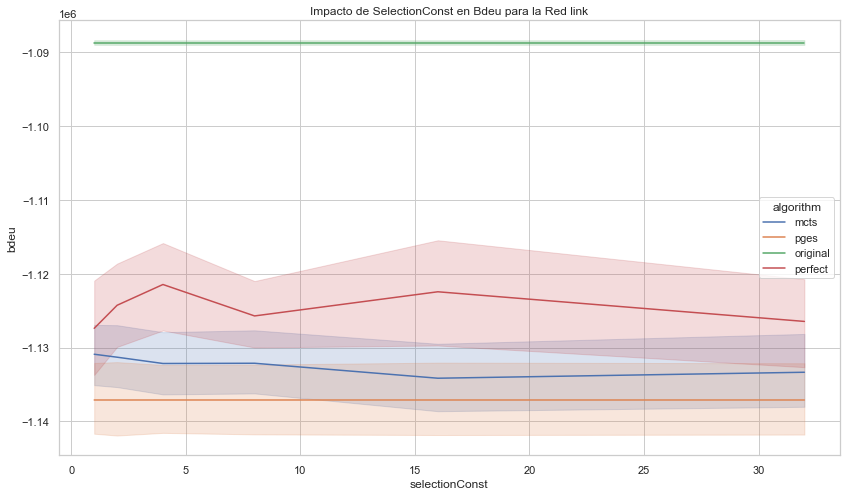

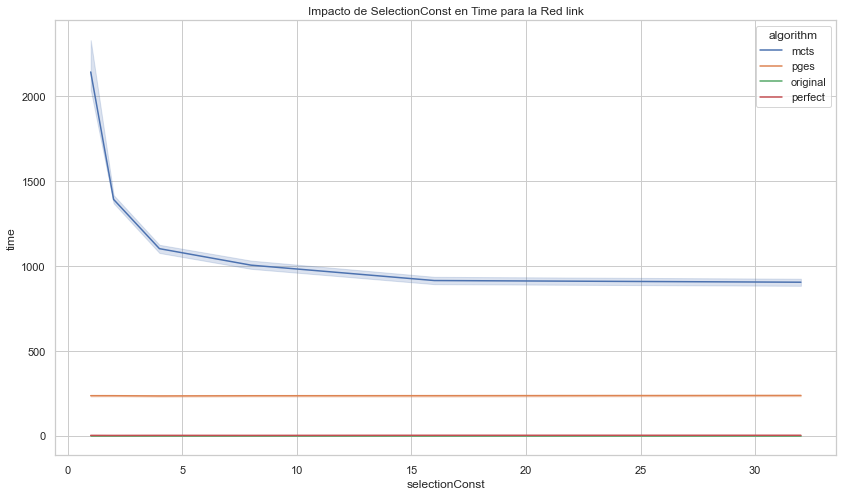

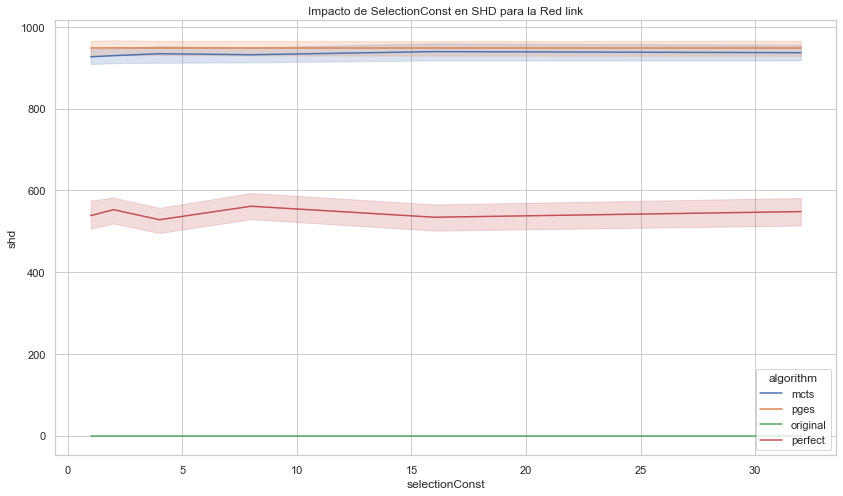

In [33]:
# ChatGPT
import matplotlib.pyplot as plt
import seaborn as sns

df = pipeline()
# Seleccionar solo los experimentos distinto de 1.0 en numSwaps y probSwap
#df = df[(df["numSwaps"] != 1.0) & (df["probSwap"] != 1.0)]
df = df[(df["numSwaps"] == 0.0) & (df["probSwap"] == 0.0)]
#df['swaps'] = df['numSwaps'].astype(str) + '-' + df['probSwap'].astype(str)
df.head()

# Selecting network
network = 'link'

# Filtrar los datos para la red munin y donde el algoritmo no sea "orig"
df_plot = df[(df['network'] == network)] #& (df['algorithm'] != 'original') & (df['algorithm'] != 'perfect')]

# Configuración de estilo de Seaborn
sns.set(style="whitegrid")

# Gráfico de línea para el impacto de SelectionConst en time
plt.figure(figsize=(14, 8))
sns.lineplot(x="selectionConst", y="bdeu", hue="algorithm", data=df_plot)
plt.title('Impacto de SelectionConst en Bdeu para la Red ' + network)
plt.show()

# Gráfico de línea para el impacto de SelectionConst en time
plt.figure(figsize=(14, 8))
sns.lineplot(x="selectionConst", y="time", hue="algorithm", data=df_plot)
plt.title('Impacto de SelectionConst en Time para la Red ' + network)
plt.show()

# Gráfico de línea para el impacto de SelectionConst en shd
plt.figure(figsize=(14, 8))
sns.lineplot(x="selectionConst", y="shd", hue="algorithm", data=df_plot)
plt.title('Impacto de SelectionConst en SHD para la Red ' + network)
plt.show()

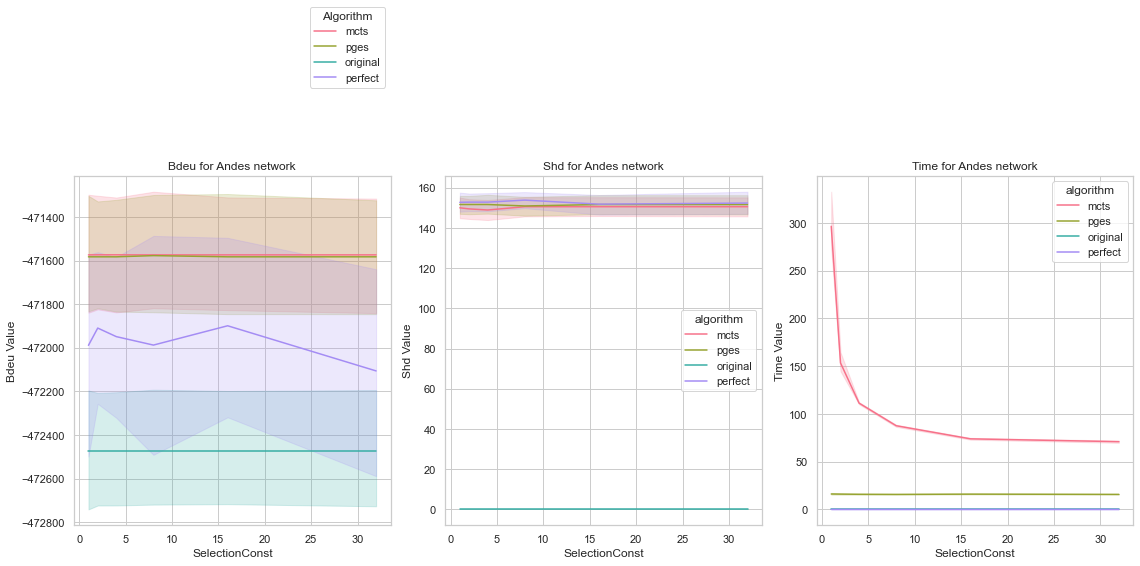

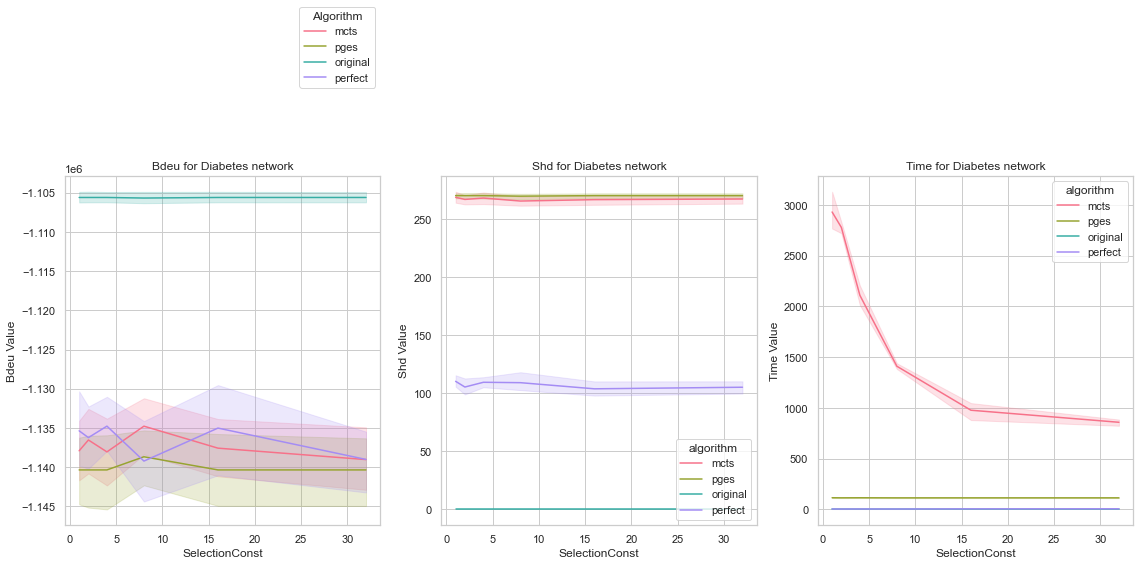

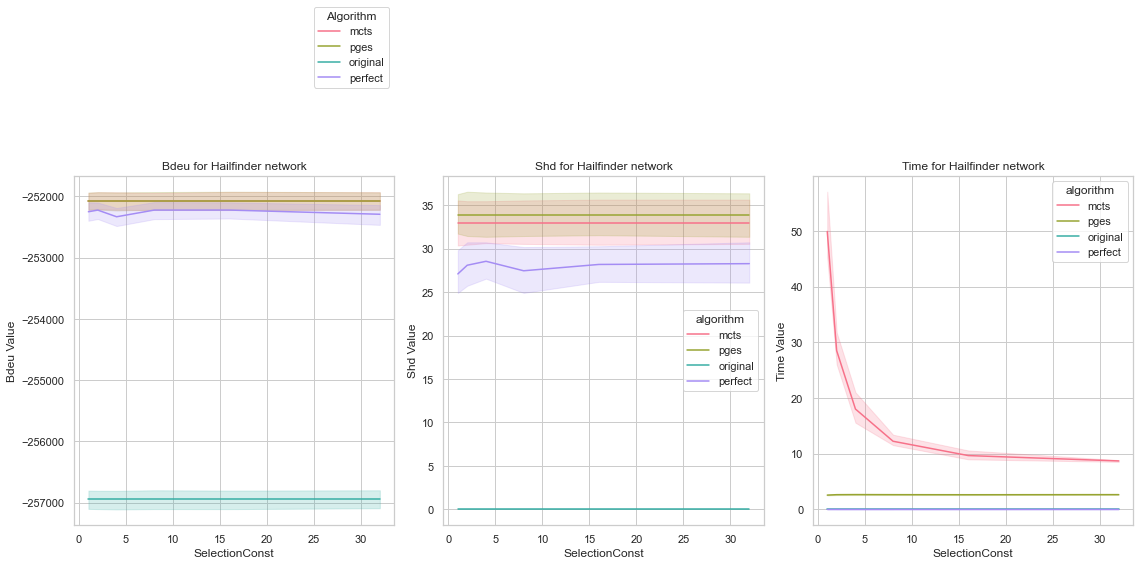

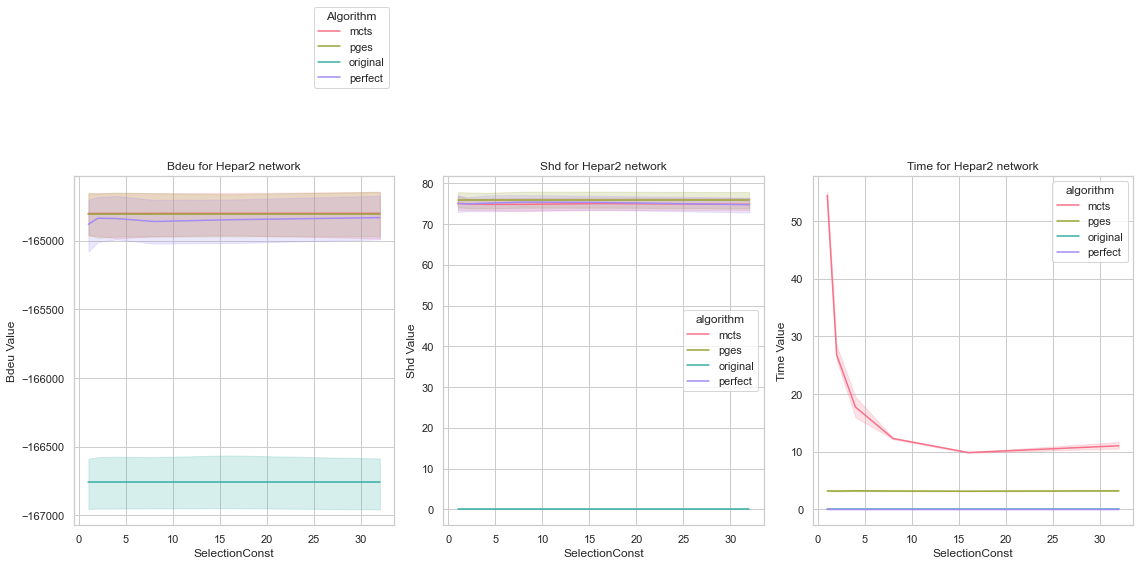

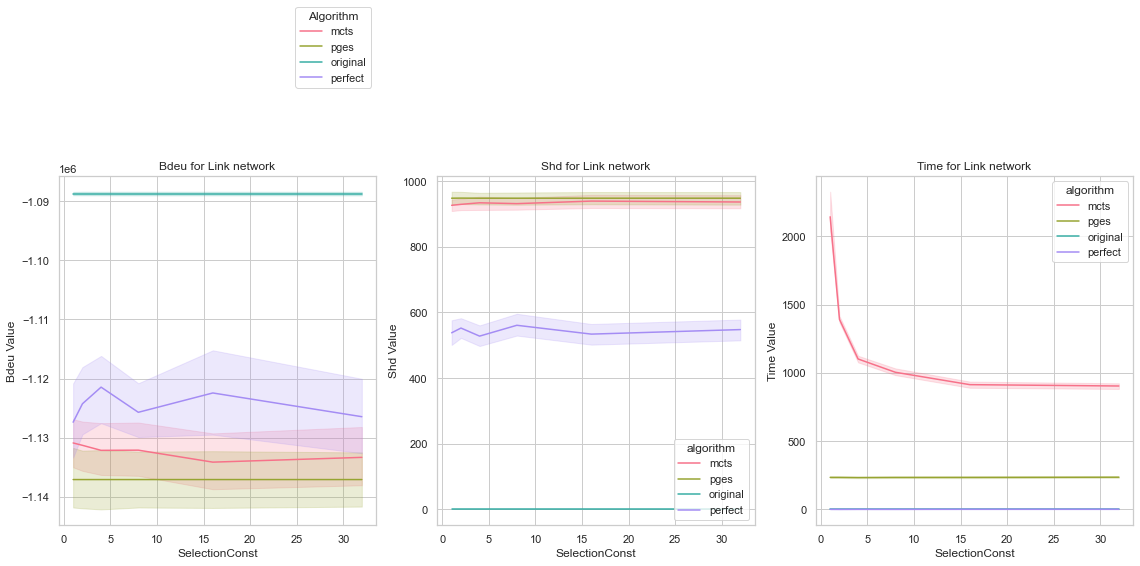

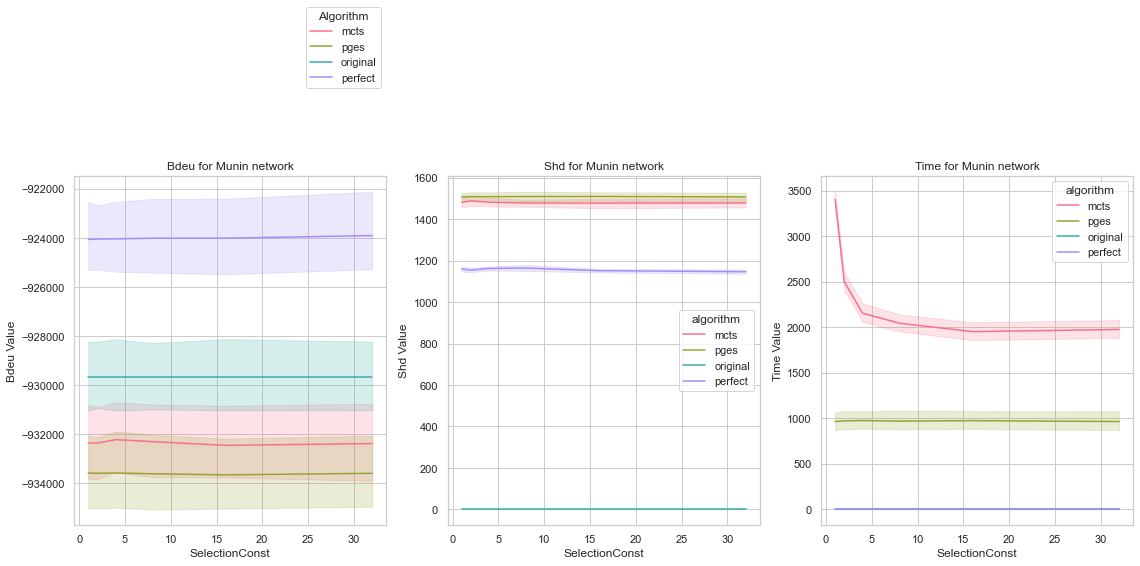

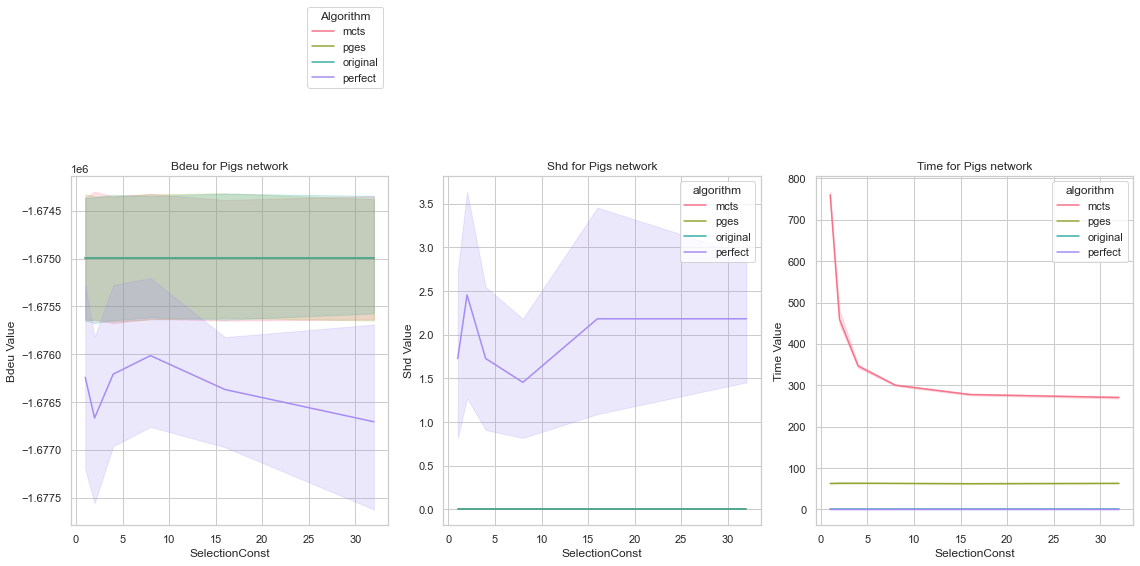

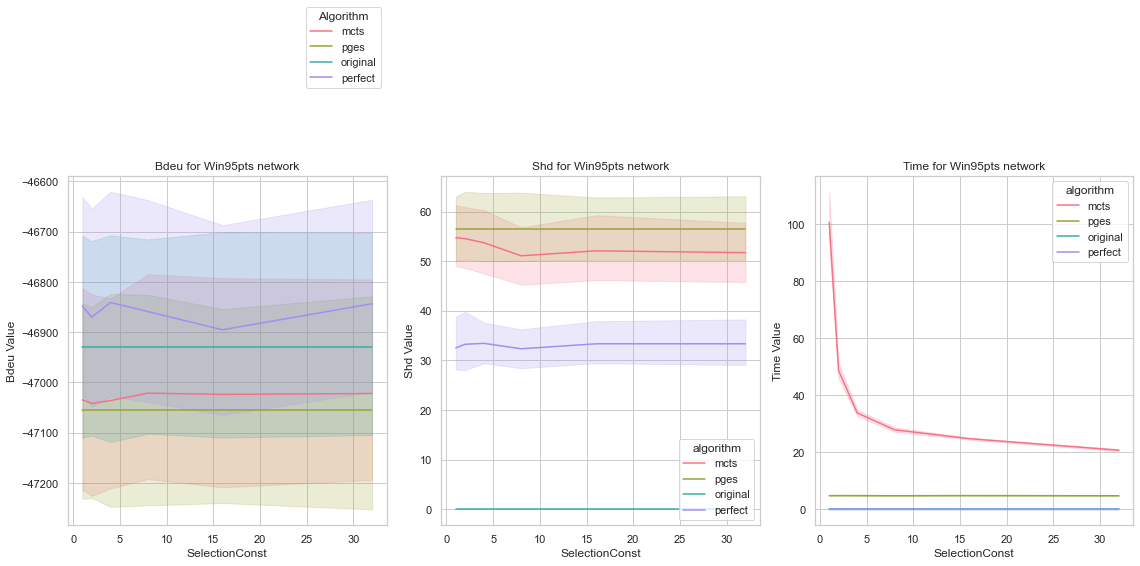

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pipeline()
# Seleccionar solo los experimentos iguales a 1.0 en numSwaps y probSwap
df = df[(df["numSwaps"] == 0.0) & (df["probSwap"] == 0.0)]

for network in df['network'].unique():

    # Filtrar los datos para la red 'munin' y donde el algoritmo no sea 'orig'
    df_plot = df[(df['network'] == network)]

    # Configuración de estilo de Seaborn
    sns.set(style="whitegrid")

    # Crear subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 9), sharex=True)

    # Mapa de colores según la métrica
    palette = sns.color_palette("husl", n_colors=len(df_plot['algorithm'].unique()))

    # Gráficos de línea para cada métrica
    for i, metric in enumerate(['bdeu', 'shd', 'time']):
        sns.lineplot(x="selectionConst", y=metric, hue="algorithm", data=df_plot, palette=palette, ax=axes[i])
        axes[i].set_title(f'{metric.capitalize()} for {network.capitalize()} network')
        axes[i].set_xlabel('SelectionConst')
        axes[i].set_ylabel(f'{metric.capitalize()} Value')

    # Añadir leyenda
    axes[0].legend(title="Algorithm", bbox_to_anchor=(1, 1.5))

    # Guardar figura
    strFile =f'../plots/mctsbn-distributed/{network}_metrics.png'
    if os.path.isfile(strFile):
        os.remove(strFile)   # Opt.: os.system("rm "+strFile)
    plt.savefig(strFile, bbox_inches='tight', dpi=300,)

    # Ajustar diseño
    plt.tight_layout()
    plt.show()


In [35]:
df.head()

,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471620.756706,164.0,277.743
9,andes,8,0.0,0.0,mcts,-471620.756706,164.0,87.901
18,andes,4,0.0,0.0,mcts,-471620.756706,164.0,111.014
27,andes,32,0.0,0.0,mcts,-471620.756706,164.0,70.579
36,andes,2,0.0,0.0,mcts,-471620.756706,164.0,138.449


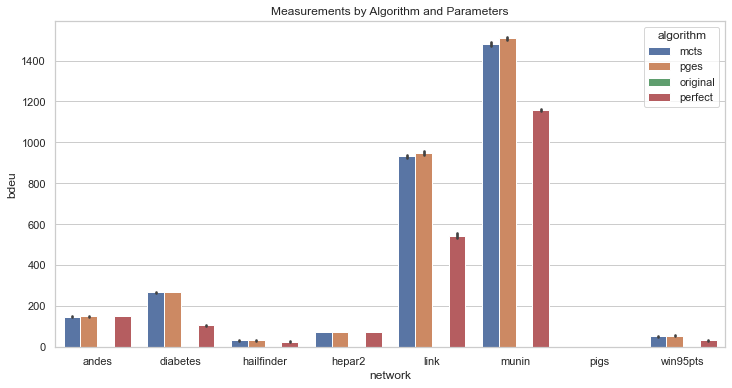

In [36]:
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=df,x='network', y='shd', hue='algorithm')
plt.title('Measurements by Algorithm and Parameters')
plt.xlabel('network')
plt.ylabel('bdeu')
plt.show()

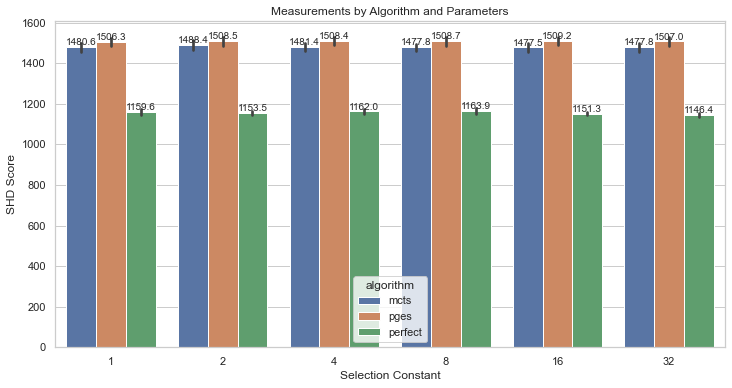

In [37]:
network="munin"
df_plot = df.loc[(df["network"]==network) & (df["algorithm"] != "original")]

#ax = sns.barplot(flights, x="year", y="passengers", estimator="sum", errorbar=None)
#ax.bar_label(ax.containers[0], fontsize=10);

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_plot,x='selectionConst', y='shd', hue="algorithm")
for container in ax.containers:
    ax.bar_label(container, fontsize=10, fmt='%.1f')

plt.title('Measurements by Algorithm and Parameters')
plt.xlabel('Selection Constant')
plt.ylabel('SHD Score')
plt.show()

## Exreport

In [38]:
df

,network,selectionConst,numSwaps,probSwap,algorithm,bdeu,shd,time
0,andes,1,0.0,0.0,mcts,-471620.756706,164.0,277.743
9,andes,8,0.0,0.0,mcts,-471620.756706,164.0,87.901
18,andes,4,0.0,0.0,mcts,-471620.756706,164.0,111.014
27,andes,32,0.0,0.0,mcts,-471620.756706,164.0,70.579
36,andes,2,0.0,0.0,mcts,-471620.756706,164.0,138.449
...,...,...,...,...,...,...,...,...
18931,win95pts,8,0.0,0.0,perfect,-46803.642264,32.0,0.025
18940,win95pts,4,0.0,0.0,perfect,-46790.057561,34.0,0.019
18949,win95pts,32,0.0,0.0,perfect,-46790.057561,34.0,0.018
18958,win95pts,2,0.0,0.0,perfect,-46804.375793,28.0,0.019


In [39]:
import os
import shutil
# Crear una copia de df llamada df_exreport
df_exreport = df.copy()

# Crear una columna con las configuraciones separadas por espacio. Los valores de las configuraciones están en las columnas threads y broadcasting
df_exreport['config'] = "mctsbn_distributed-" + df_exreport['selectionConst'].astype(str) #+ '-' + df_exreport['numSwaps'].astype(str) + '-' + df_exreport['probSwap'].astype(str)

# Eliminar las columnas usadas para crear la columna config
#df_exreport = df_exreport.drop(['selectionConst', 'numSwaps', 'probSwap'], axis=1)

df_exreport = df_exreport.groupby(["config", "network"],observed=True).mean().reset_index()

# Redondear a 4
df_exreport = df_exreport.round(4)

#print(df_exreport)
print(df_exreport.columns)

# Write to csv ./exreport/exreport.csv
df_exreport.to_csv('./exreport/exreport.csv', index=False)

# Delete folder exreport_output and its content if exists
if os.path.exists('./exreport/exreport_output'):
    shutil.rmtree('./exreport/exreport_output')

# Execute exreport.r
os.system('Rscript ./exreport/exreport.r')

Index(['config', 'network', 'selectionConst', 'numSwaps', 'probSwap', 'bdeu',
       'shd', 'time'],
      dtype='object')


<ipython-input-39-43c14bb6edc5>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_exreport = df_exreport.groupby(["config", "network"],observed=True).mean().reset_index()


512

# Resultados por iteraciones

In [40]:
def preprocess_iterations(df_iterations):
    # Crear una nueva columna llamada selectionConst que sea el resultado de dividir 10000 entre el límite de iteraciones, y convertirlo a int
    df_iterations['selectionConst'] = 10000 / df_iterations['itLimit']
    df_iterations['selectionConst'] = df_iterations['selectionConst'].astype(int)
    # Eliminar columnas
    df_iterations = df_iterations.drop(['algorithm', 'itLimit', 'threads', 'exploitConst'], axis=1)
    # Descartar numSwaps y probSwap distiontos a 0.0
    df_iterations = df_iterations[(df_iterations["numSwaps"] == 0.0) & (df_iterations["probSwap"] == 0.0)]
    df_iterations = df_iterations.drop(['numSwaps', 'probSwap'], axis=1)

    # Adding one to iterations
    df_iterations['iteration'] = df_iterations['iteration'] + 1
    return df_iterations
    
    

In [41]:
df_iterations = preprocess_iterations(pd.read_csv(path_results_iterations))
df_iterations.head()

,network,bbdd,bdeuMCTS,iteration,time,selectionConst
0,andes,andes.xbif50001246_,-471620.756706,1,0.051,1
1,andes,andes.xbif50001246_,-471620.756706,2,0.028,1
2,andes,andes.xbif50001246_,-471620.756706,3,0.031,1
3,andes,andes.xbif50001246_,-471620.756706,4,0.036,1
4,andes,andes.xbif50001246_,-471620.756706,5,0.046,1


<ipython-input-42-4faada1f5572>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_plot = df_iterations[df_iterations["network"] == network].groupby(["network", "selectionConst", "iteration"],as_index=False).mean()


<AxesSubplot:xlabel='iteration', ylabel='bdeuMCTS'>

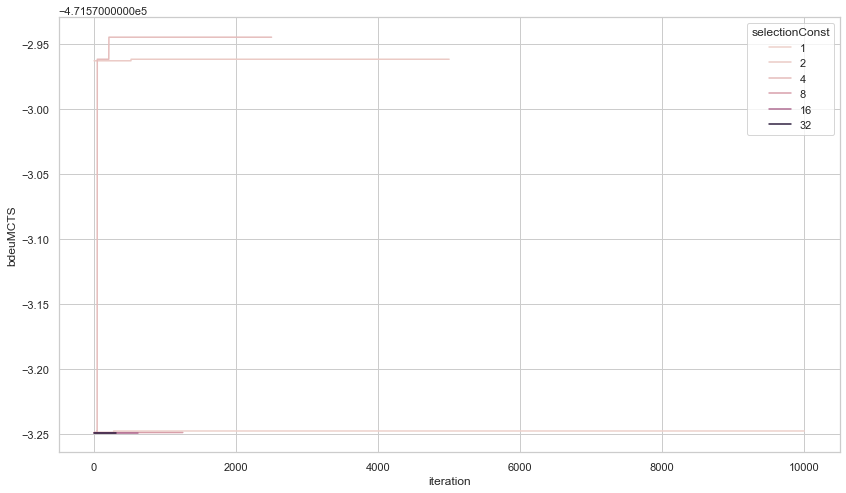

In [42]:
# lineplot
network = "andes"
selectionConst = 2

df_plot = df_iterations[df_iterations["network"] == network].groupby(["network", "selectionConst", "iteration"],as_index=False).mean()
#df_plot = df_plot[df_plot["selectionConst"] == selectionConst]
#print(len(df_plot))
#df_plot

# Hacer la imagen más grande
plt.figure(figsize=(14, 8))

sns.lineplot(data=df_plot, x="iteration", y="bdeuMCTS",hue="selectionConst")

In [43]:
# df_it iteration = iteration + 1

In [44]:
# Order of networks: child, insurance, water, mildew, alarm, barley, hailfinder, hepar2, win95pts, pathfinder, andes, diabetes, pigs, link, munin
x_order=['child', 'insurance', 'water', 'mildew', 'alarm', 'barley', 'hailfinder', 'hepar2', 'win95pts', 'pathfinder', 'andes', 'diabetes', 'pigs', 'link', 'munin']

In [45]:
# Only mantain iterations 0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000 and 9999
#df_it = df_it[df_it['iteration'].isin([0, 1, 2, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999])]

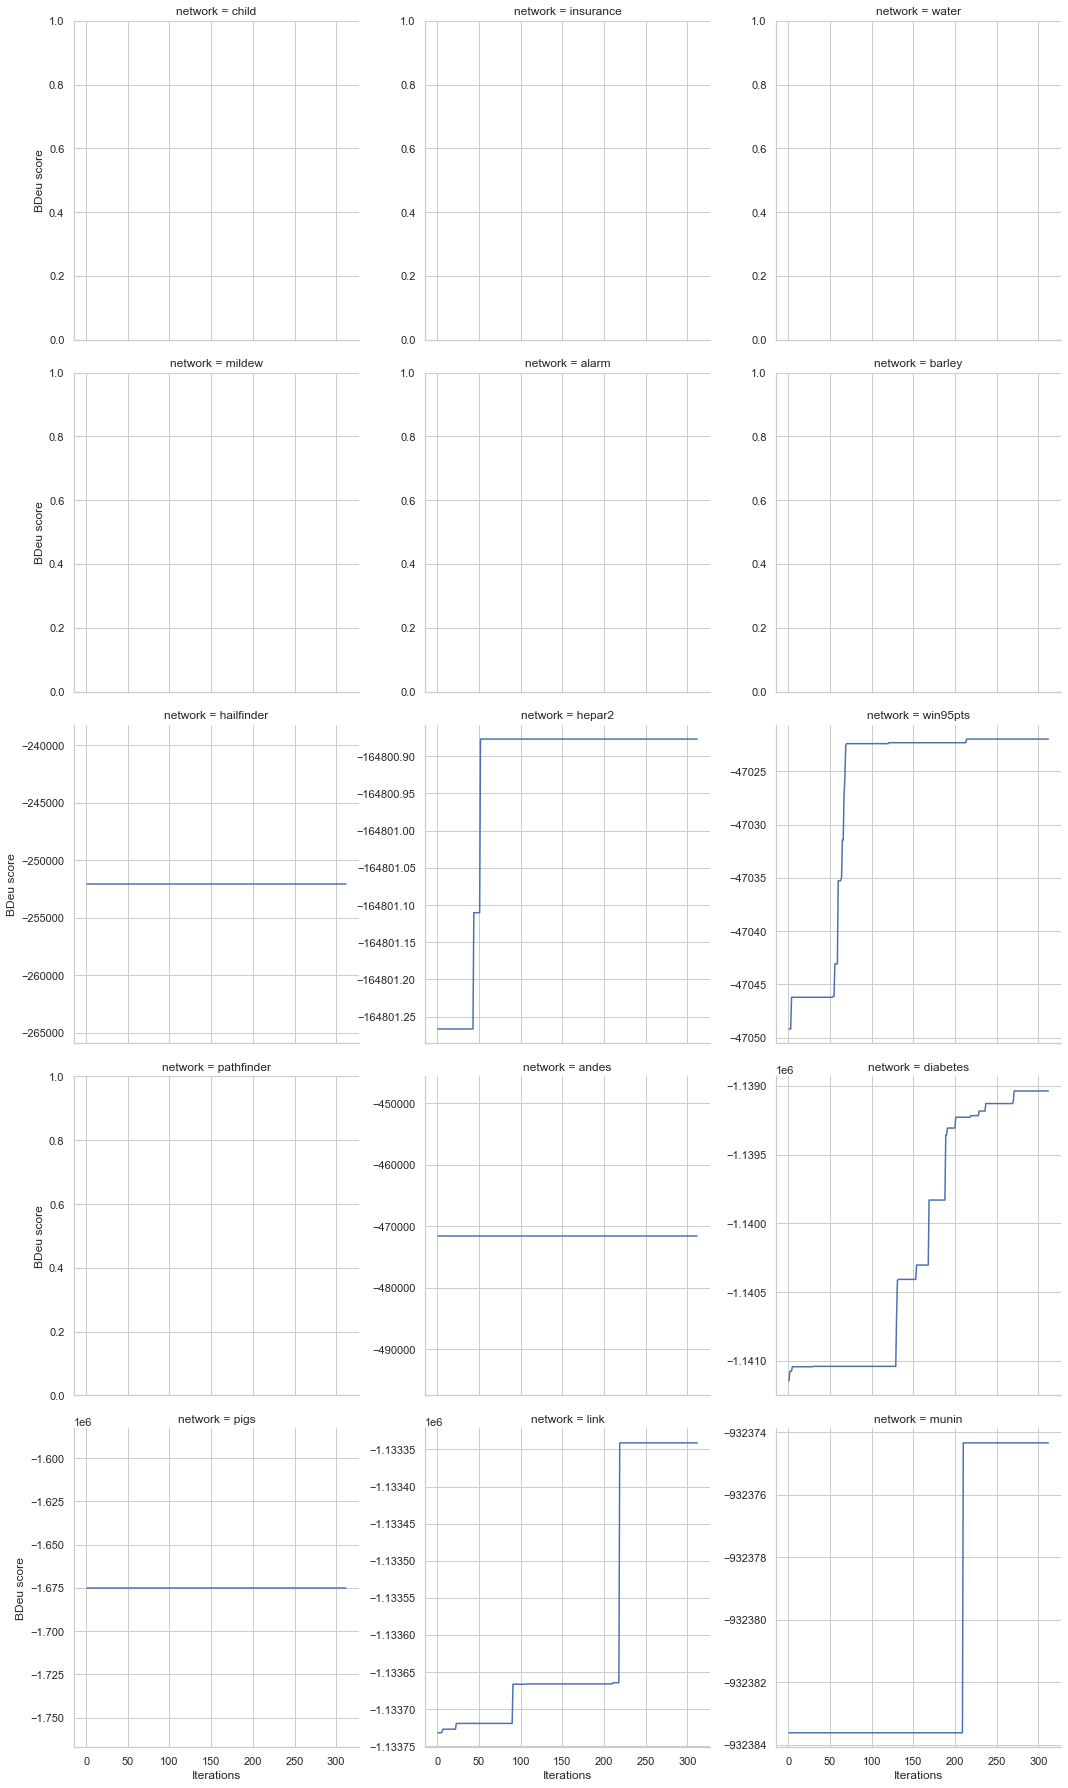

In [51]:
# Plot BDeu score vs iterations for each network
selectionConst = 32
g = sns.relplot(data=df_iterations[df_iterations["selectionConst"] == selectionConst], x='iteration', y='bdeuMCTS', col='network', kind='line', col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, col_order=x_order, ci=None)

# Set axis labels
g.set_axis_labels("Iterations", "BDeu score")

for ax in g.axes.flat:
    ax.ticklabel_format(useOffset=False)

In [47]:
df_iterations.head()

,network,bbdd,bdeuMCTS,iteration,time,selectionConst
0,andes,andes.xbif50001246_,-471620.756706,1,0.051,1
1,andes,andes.xbif50001246_,-471620.756706,2,0.028,1
2,andes,andes.xbif50001246_,-471620.756706,3,0.031,1
3,andes,andes.xbif50001246_,-471620.756706,4,0.036,1
4,andes,andes.xbif50001246_,-471620.756706,5,0.046,1


In [48]:
df_tidy[df_tidy["algorithm"] == "pges"].groupby(["network", "selectionConst", "numSwaps", "probSwap"], as_index=False).mean()

<ipython-input-48-7dc65f977055>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tidy[df_tidy["algorithm"] == "pges"].groupby(["network", "selectionConst", "numSwaps", "probSwap"], as_index=False).mean()


,network,selectionConst,numSwaps,probSwap,bdeu,shd,time
0,andes,1,0.0,0.0,-471582.205027,151.727273,16.157273
1,andes,1,0.0,0.5,-471576.681467,151.000000,15.661636
2,andes,1,0.0,1.0,-471576.681467,151.000000,15.780818
3,andes,1,0.5,0.0,-471582.205027,151.727273,15.739000
4,andes,1,0.5,0.5,-471582.205027,151.727273,15.731818
...,...,...,...,...,...,...,...
427,win95pts,32,0.5,0.5,-47054.862053,56.454545,4.764182
428,win95pts,32,0.5,1.0,-47054.862053,56.454545,4.772545
429,win95pts,32,1.0,0.0,-47054.862053,56.454545,4.746727
430,win95pts,32,1.0,0.5,-47054.862053,56.454545,4.743818


In [49]:
# BOOKMARK!!!!
df_tidy[df_tidy["algorithm"] == "pges"].groupby(["network", "selectionConst", "numSwaps", "probSwap"], as_index=False).mean()

<ipython-input-49-3468ee7a1cbd>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_tidy[df_tidy["algorithm"] == "pges"].groupby(["network", "selectionConst", "numSwaps", "probSwap"], as_index=False).mean()


,network,selectionConst,numSwaps,probSwap,bdeu,shd,time
0,andes,1,0.0,0.0,-471582.205027,151.727273,16.157273
1,andes,1,0.0,0.5,-471576.681467,151.000000,15.661636
2,andes,1,0.0,1.0,-471576.681467,151.000000,15.780818
3,andes,1,0.5,0.0,-471582.205027,151.727273,15.739000
4,andes,1,0.5,0.5,-471582.205027,151.727273,15.731818
...,...,...,...,...,...,...,...
427,win95pts,32,0.5,0.5,-47054.862053,56.454545,4.764182
428,win95pts,32,0.5,1.0,-47054.862053,56.454545,4.772545
429,win95pts,32,1.0,0.0,-47054.862053,56.454545,4.746727
430,win95pts,32,1.0,0.5,-47054.862053,56.454545,4.743818


In [50]:
df_unstack = df.drop(["exploitConst", "numSwaps", "probSwap", "bbdd", "shdMCTS", "bdeuMCTS", "shdPGES", "bdeuOrig", "shdOrig", "bdeuPerfect", "shdPerfect", "time", "timePGES"], axis=1) # "bdeuPGES"
meanBDeu = df_unstack.groupby(["network"], observed=True).mean()

# Concat the results of PGES as iteration = 0
for network in df_iterations['network'].unique():
    line = pd.DataFrame({'algorithm': ['pGES'], 'network': [network], 'bbdd': [network], 'bdeuMCTS': [meanBDeu['bdeuPGES'][network]], 'iteration': [0], 'time': [0]})
    df_iterations = pd.concat([df_iterations, line], axis=0)

KeyError: "['exploitConst', 'bbdd', 'shdMCTS', 'bdeuMCTS', 'shdPGES', 'bdeuOrig', 'shdOrig', 'bdeuPerfect', 'shdPerfect', 'timePGES'] not found in axis"

In [ ]:
# Plot BDeu score vs iterations for each network
g = sns.relplot(data=df_it, x='iteration', y='bdeuMCTS', col='network', kind='line', col_wrap=3, facet_kws={'sharey': False, 'sharex': True}, col_order=x_order, ci=None)

# Set axis labels
g.set_axis_labels("Iterations", "BDeu score")

for ax in g.axes.flat:
    ax.ticklabel_format(useOffset=False)

# Línea con valor de BDeu de PGES y el HC con mejor órden para cada red
for ax in g.axes:
    # get the network of the axes
    network = ax.get_title().split('=')[1].strip()

    # line of PGES
    ax.axhline(meanBDeu['bdeuPGES'][network], color='red', linestyle='--', label='PGES')

    # line of HC
    ax.axhline(meanBDeu['bdeuHC'][network], color='green', linestyle='-', label='HC')